In [1]:
teachers = 1884



# 1. Importing libriries and data

In [2]:
import warnings
warnings.filterwarnings('ignore')

import time

import pandas as pd
import numpy as np
import re
from collections import Counter
import random
from sklearn.utils import shuffle


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor

In [3]:
RANDOM_STATE = 0

In [4]:
data = pd.read_csv(f'teachers_{teachers}.csv')

In [5]:
data.head()

,link,teacher_type,is_native,languages,about_info,since_date,main_info,country_from,country_living,rating,students_num,lessons_num,attendance,response,target,teacher_style,lessons_style,resume,reviews_num
0,https://www.italki.com/en/teacher/9453623/english,PROFESSIONAL TEACHER,Teaches\nEnglish\nNative,['Other'],I am a native English speaker born and raised ...,"italki teacher since Jul 17, 2021","Certified IELTS, Level 5 TEFL, and IBET instru...",From United States,"Living in Bandung, Indonesia (17:09 UTC+07:00)",4.9,38,79,99%,100%,USD 10.00,As a teacher I have had the pleasure of helpin...,In my lessons I give the student a foundation ...,IELTS IELTS Operations Australia 2022\nCertifi...,12 Reviews
1,https://www.italki.com/en/teacher/12009826/eng...,PROFESSIONAL TEACHER,Teaches\nEnglish\nNative,"['Spanish', 'Other']","Hello, I'm Rachel from England but I now and l...","italki teacher since Jan 27, 2022",Certified TEFL Teacher with 10 years teaching ...,From United Kingdom,"Living in Alacant, Spain (11:09 UTC+01:00)",5.0,35,161,100%,99%,USD 5.00,For me it is important that my students enjoy ...,For the structured lessons we use the Cambridg...,TEFL The TEFL Academy 2015\nCertificate uploaded,12 Reviews
2,https://www.italki.com/en/teacher/3011731/english,COMMUNITY TUTOR,Teaches\nEnglish\nNative\nSpanish,"['Arabic', 'Indonesian']","I'm originally from the US, though today I pre...","italki teacher since Aug 30, 2016","I'm originally from the US, though today I pre...",From United States,"Living in Tucheng, Taiwan (18:09 UTC+08:00)",4.7,546,735,99%,98%,USD 5.00,I've been teaching on italki for about 2 years...,My lessons are mostly conversational and light...,NaN,157 Reviews
3,https://www.italki.com/en/teacher/10883180/eng...,COMMUNITY TUTOR,Teaches\nEnglish\nNative,['Other'],"My name is Yondela, I am a Bsc (Biochemistry, ...","italki teacher since Oct 22, 2021",BSc graduate with 1 year of experience as an o...,From South Africa,"Living in Nelson Mandela, South Africa (12:09 ...",4.9,20,34,97%,100%,USD 5.00,I am a patient and understanding teacher. I ha...,"In my lessons we will use magazines, pictures,...",NaN,5 Reviews
4,https://www.italki.com/en/teacher/9779566/english,COMMUNITY TUTOR,Teaches\nEnglish\nNative,[],Hi ! My name is Ayanda from a beautiful countr...,"italki teacher since Oct 27, 2021",certified TEFL teacher (ADULT & CHILDREN),From South Africa,"Living in Ethekwini, South Africa (12:10 UTC+0...",4.9,90,162,99%,100%,USD 5.00,"I am a very patient and understanding person ,...",My teaching style will be interactive and supp...,NaN,40 Reviews


# 2. EDA (Exploratory Data Analysis)

## 2.1. Duplicates removing

In [6]:
data.shape

(1884, 19)

In [7]:
data.drop_duplicates(inplace=True)
data.shape

(1884, 19)

There aren't any duplicates in train data.

## 2.2. Explore columns

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1884 entries, 0 to 1883
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   link            1884 non-null   object 
 1   teacher_type    1884 non-null   object 
 2   is_native       1883 non-null   object 
 3   languages       1884 non-null   object 
 4   about_info      1714 non-null   object 
 5   since_date      1884 non-null   object 
 6   main_info       1884 non-null   object 
 7   country_from    1884 non-null   object 
 8   country_living  1884 non-null   object 
 9   rating          1880 non-null   float64
 10  students_num    1880 non-null   object 
 11  lessons_num     1880 non-null   object 
 12  attendance      1880 non-null   object 
 13  response        1880 non-null   object 
 14  target          1884 non-null   object 
 15  teacher_style   1850 non-null   object 
 16  lessons_style   1846 non-null   object 
 17  resume          770 non-null    o

In [9]:
# Shuffle data

data = shuffle(data, random_state=RANDOM_STATE)
data.index = range(data.shape[0])

<AxesSubplot:>

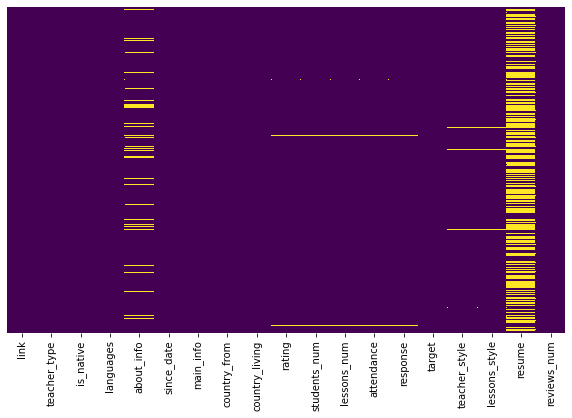

In [10]:
plt.figure(figsize = (10,6))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False,  cmap='viridis')

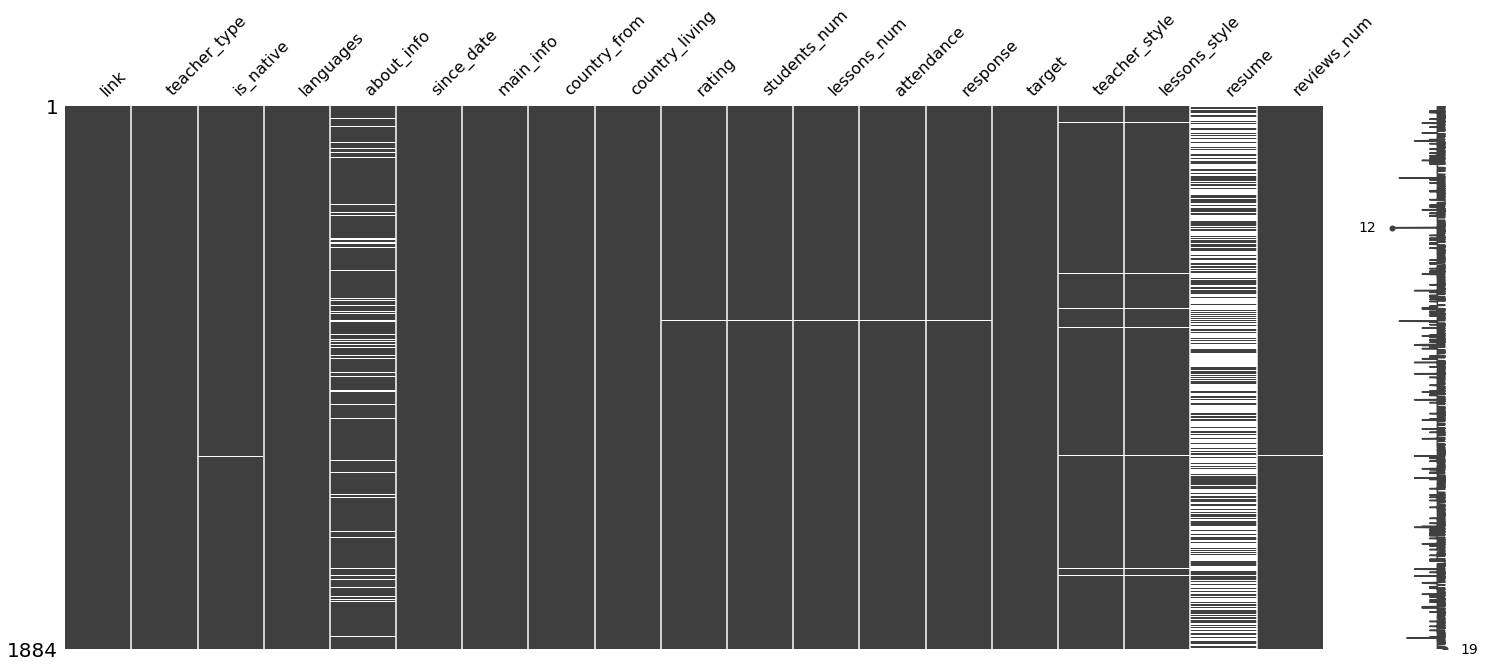

In [11]:
missingno.matrix(data)
plt.show()

There are few columns with missed data:
 - 'resume' column has a huge amount of missing data. May be we will delete it, add info to another column or use info if this info has been provided.
 - 'about_info' column has a lot of missing data. May be we will add info to another column or use info if this info has been provided.
 - 'rating', 'students_num', 'lessons_num', 'attendance', 'response', 'teacher_style',
    ' lessons_style' columns have just few missing values. We will impute it separetly.

### 2.2.1 'Target' column.

Trial lesson price we need to predict.

In [12]:
data.target.value_counts()

USD 5.00                        773
USD 10.00                       202
USD 8.00                        148
USD 6.00                        148
USD 7.00                        129
                               ... 
USD 5.20                          1
USD 5.70                          1
Hourly rate from\nUSD 8.00+       1
Hourly rate from\nUSD 17.99+      1
Hourly rate from\nUSD 15.50+      1
Name: target, Length: 96, dtype: int64

We can see, that there are  values which are different from common. I suppose it means that this teacher doesn't provide such type of lesson as trial. We need to delete them.

In [13]:
data[data.target.str.match(r'(^USD*)')==False].target

86      Hourly rate from\nUSD 12.00+
174     Hourly rate from\nUSD 12.00+
212     Hourly rate from\nUSD 14.00+
273     Hourly rate from\nUSD 18.00+
284     Hourly rate from\nUSD 12.00+
503     Hourly rate from\nUSD 16.00+
533     Hourly rate from\nUSD 35.00+
617     Hourly rate from\nUSD 20.00+
651     Hourly rate from\nUSD 63.00+
667     Hourly rate from\nUSD 15.00+
674     Hourly rate from\nUSD 25.00+
686     Hourly rate from\nUSD 15.00+
796     Hourly rate from\nUSD 16.00+
946     Hourly rate from\nUSD 25.00+
1031    Hourly rate from\nUSD 10.00+
1059    Hourly rate from\nUSD 15.00+
1065    Hourly rate from\nUSD 25.00+
1166    Hourly rate from\nUSD 20.00+
1179    Hourly rate from\nUSD 20.00+
1207    Hourly rate from\nUSD 10.00+
1239    Hourly rate from\nUSD 20.00+
1279    Hourly rate from\nUSD 12.00+
1330     Hourly rate from\nUSD 8.00+
1368    Hourly rate from\nUSD 12.50+
1379    Hourly rate from\nUSD 14.50+
1387    Hourly rate from\nUSD 15.50+
1390    Hourly rate from\nUSD 28.00+
1

In [14]:
data = data[data.target.str.match(r'(^USD*)')==True]
data.index = range(data.shape[0])

In [15]:
data.shape

(1853, 19)

In [16]:
data.target.unique()

array(['USD 5.00', 'USD 15.00', 'USD 8.00', 'USD 6.99', 'USD 7.50',
       'USD 7.95', 'USD 7.80', 'USD 12.00', 'USD 6.31', 'USD 10.00',
       'USD 20.00', 'USD 6.00', 'USD 7.00', 'USD 7.99', 'USD 11.00',
       'USD 24.00', 'USD 23.50', 'USD 9.00', 'USD 6.50', 'USD 23.00',
       'USD 14.00', 'USD 13.00', 'USD 9.50', 'USD 18.00', 'USD 19.90',
       'USD 11.99', 'USD 10.50', 'USD 16.00', 'USD 8.20', 'USD 22.00',
       'USD 19.00', 'USD 25.00', 'USD 9.99', 'USD 5.50', 'USD 9.90',
       'USD 14.99', 'USD 6.75', 'USD 33.00', 'USD 13.25', 'USD 6.95',
       'USD 24.98', 'USD 5.70', 'USD 5.99', 'USD 8.88', 'USD 12.50',
       'USD 15.60', 'USD 17.00', 'USD 9.47', 'USD 9.95', 'USD 5.75',
       'USD 12.78', 'USD 9.88', 'USD 5.83', 'USD 30.00', 'USD 10.88',
       'USD 8.80', 'USD 11.50', 'USD 18.50', 'USD 51.00', 'USD 8.50',
       'USD 26.00', 'USD 5.20', 'USD 35.00', 'USD 7.90', 'USD 9.80',
       'USD 10.99', 'USD 7.75', 'USD 29.00', 'USD 7.58', 'USD 5.30',
       'USD 36.00', 'USD 10

Let's make it float.

In [17]:
data['target'] = [float(x.split(' ')[1]) for x in data.target]

In [18]:
data.target.unique()

array([ 5.  , 15.  ,  8.  ,  6.99,  7.5 ,  7.95,  7.8 , 12.  ,  6.31,
       10.  , 20.  ,  6.  ,  7.  ,  7.99, 11.  , 24.  , 23.5 ,  9.  ,
        6.5 , 23.  , 14.  , 13.  ,  9.5 , 18.  , 19.9 , 11.99, 10.5 ,
       16.  ,  8.2 , 22.  , 19.  , 25.  ,  9.99,  5.5 ,  9.9 , 14.99,
        6.75, 33.  , 13.25,  6.95, 24.98,  5.7 ,  5.99,  8.88, 12.5 ,
       15.6 , 17.  ,  9.47,  9.95,  5.75, 12.78,  9.88,  5.83, 30.  ,
       10.88,  8.8 , 11.5 , 18.5 , 51.  ,  8.5 , 26.  ,  5.2 , 35.  ,
        7.9 ,  9.8 , 10.99,  7.75, 29.  ,  7.58,  5.3 , 36.  , 10.95,
       19.99, 29.99,  8.75,  5.58,  8.4 , 17.5 ,  6.58])

In [19]:
data.target.describe()

count    1853.000000
mean        7.820815
std         4.046438
min         5.000000
25%         5.000000
50%         6.000000
75%        10.000000
max        51.000000
Name: target, dtype: float64

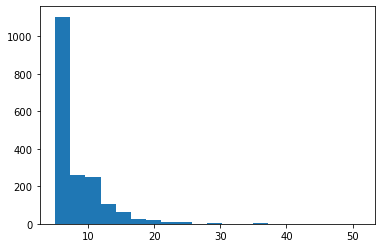

In [20]:
plt.hist(data.target,20)
plt.show()

As we can see there is a long tail. We will delete 1% of data with the biggest price.

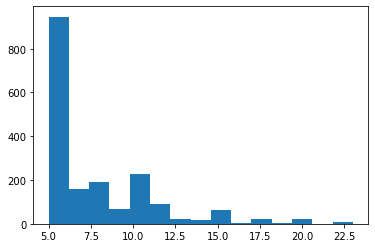

In [21]:
q2 = data.target.quantile(0.99)
data = data[data.target<q2]
plt.hist(data.target,15)
plt.show()

In [22]:
data.target.describe()

count    1834.000000
mean        7.606598
std         3.410179
min         5.000000
25%         5.000000
50%         6.000000
75%         9.990000
max        23.000000
Name: target, dtype: float64

In [23]:
data.shape

(1834, 19)

In [24]:
data.index = range(data.shape[0])

In [25]:
data.head()

,link,teacher_type,is_native,languages,about_info,since_date,main_info,country_from,country_living,rating,students_num,lessons_num,attendance,response,target,teacher_style,lessons_style,resume,reviews_num
0,https://www.italki.com/en/teacher/13239573/eng...,COMMUNITY TUTOR,Teaches\nEnglish\nNative,"['Tswana', 'Other']","I am 23 years, I'm from Botswana and I am curr...","italki teacher since Mar 30, 2022","Certified TEFL teacher, food blogger and under...",From Botswana,"Living in Other, Botswana (16:25 UTC+02:00)",4.9,91,348,100%,100%,5.0,"I am a friend rather a teacher, a fun and outg...",Student oriented and repetitive: my lessons ar...,NaN,42 Reviews
1,https://www.italki.com/en/teacher/10852484/eng...,PROFESSIONAL TEACHER,Teaches\nEnglish\nNative,"['Pashto', 'Hindi', 'Urdu', 'Korean']",I'm Raheena from the UK/British Native English...,"italki teacher since Dec 11, 2021",Certified British TEFL Teacher with over 5 yea...,From United Kingdom,"Living in Seoul, Republic of Korea (19:26 UTC+...",5.0,62,230,100%,100%,15.0,I have experience of teaching English in South...,"My teaching philosophy is all about, doing som...",2018 - 2019\nNative English Teacher FTK\nFTK -...,23 Reviews
2,https://www.italki.com/en/teacher/12640758/eng...,PROFESSIONAL TEACHER,Teaches\nEnglish\nNative,['Other'],"Hello and welcome, I'm Mindy. I am an American...","italki teacher since Mar 1, 2022",TEFL Certified Teacher: I specialize in conver...,From United States,"Living in Cork, Ireland (11:19 UTC+00:00)",5.0,25,191,100%,100%,8.0,I am a native English speaker and a TEFL certi...,"My lessons are quite informal, but I do provid...",2019 - 2021\nBaker/Chef Farmgate Cafe\nFarmgat...,10 Reviews
3,https://www.italki.com/en/teacher/11348793/eng...,COMMUNITY TUTOR,Teaches\nEnglish\nNative,['Other'],"Hello, my name is Ayesha and I am Native Engl...","italki teacher since Nov 22, 2021",Qualified English Teacher🌈,From South Africa,"Living in Johannesburg, South Africa (12:29 UT...",4.8,35,127,100%,93%,5.0,Apart from having many years of experience tea...,I create fun and creative lessons to suit each...,2018 - 2021\nBachelor's - Education\nUniversit...,13 Reviews
4,https://www.italki.com/en/teacher/10352311/eng...,COMMUNITY TUTOR,Teaches\nEnglish\nNative,"['Tswana', 'French']",I am a young tutor who has more than a year of...,"italki teacher since Jan 21, 2022","An experienced, passionate and patient tutor",From Botswana,"Living in Gaborone, Botswana (13:03 UTC+02:00)",5.0,7,7,100%,100%,5.0,"I am a patient, polite and motivating teacher ...",I offer conversational lessons as well as read...,"2021 - 2022\ntutor Preply\nPreply - Gaborone, ...",2 Reviews


### Divide into train and test 

In [26]:
data_test = data.sample(frac=.15, random_state=RANDOM_STATE)

In [27]:
data_train = data.iloc[list(set(data.index) - set(data_test.index))]

In [28]:
(data_test.shape[0] + data_train.shape[0]) == data.shape[0]

True

In [29]:
data.target.describe()

count    1834.000000
mean        7.606598
std         3.410179
min         5.000000
25%         5.000000
50%         6.000000
75%         9.990000
max        23.000000
Name: target, dtype: float64

In [30]:
data_test.target.describe()

count    275.000000
mean       7.596473
std        3.538349
min        5.000000
25%        5.000000
50%        6.000000
75%        9.000000
max       22.000000
Name: target, dtype: float64

In [31]:
data_train.target.describe()

count    1559.000000
mean        7.608384
std         3.388236
min         5.000000
25%         5.000000
50%         6.000000
75%        10.000000
max        23.000000
Name: target, dtype: float64

In [32]:
data_test.index= range(data_test.shape[0])
data_train.index= range(data_train.shape[0])

Prepare lists to divide columnsby type.

In [33]:
categorical_columns = []
numerical_columns = []
binary_columns = []
text_columns = []

In [34]:
data_train.columns

Index(['link', 'teacher_type', 'is_native', 'languages', 'about_info',
       'since_date', 'main_info', 'country_from', 'country_living', 'rating',
       'students_num', 'lessons_num', 'attendance', 'response', 'target',
       'teacher_style', 'lessons_style', 'resume', 'reviews_num'],
      dtype='object')

### 2.2.2 Quantity of missed data

In [35]:
def missed_data(data):
    data['missed_data'] = data.isna().sum(axis=1)

In [36]:
missed_data(data_train)
missed_data(data_test)

In [37]:
data_test.missed_data

0      0
1      1
2      0
3      1
4      0
      ..
270    2
271    1
272    0
273    0
274    1
Name: missed_data, Length: 275, dtype: int64

In [38]:
numerical_columns.append('missed_data')

### 2.2.3 'Teacher type' column.
- Professional Teacher. A highly-skilled and qualified teacher who have experience helping students reach their goals.
- Community Tutor. A native or advanced speaker who helps students through informal tutoring or speaking practice.

In [39]:
data_train.teacher_type.value_counts()

PROFESSIONAL TEACHER    829
COMMUNITY TUTOR         730
Name: teacher_type, dtype: int64

There are just 2 values, so it should be a binary feature.

<AxesSubplot:xlabel='teacher_type', ylabel='target'>

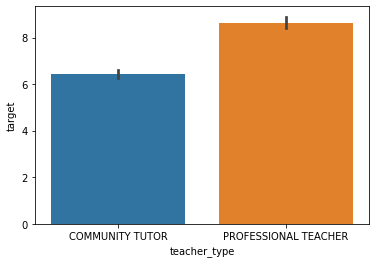

In [40]:
sns.barplot(x = 'teacher_type' ,y = 'target', data = data, estimator=np.mean)

<AxesSubplot:xlabel='teacher_type', ylabel='target'>

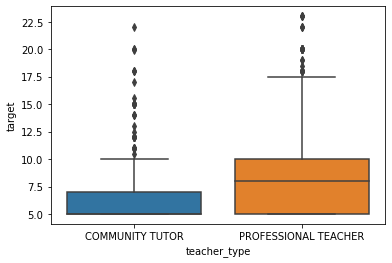

In [41]:
sns.boxplot(x = 'teacher_type', y = 'target', data = data)

In [42]:
# formula for binary columns
def binary_cols(data, column, val):
    return [1 if x == val else 0 for x in data[column]]

In [43]:
data_train.teacher_type = binary_cols(data_train, 'teacher_type', 'PROFESSIONAL TEACHER')
data_test.teacher_type = binary_cols(data_test, 'teacher_type', 'PROFESSIONAL TEACHER')

In [44]:
binary_columns.append('teacher_type')

### 2.2.3 'Is_native' column.
Info about languages which teacher teaches and if it's a native speaker or not.

In [45]:
data_train.is_native.value_counts()

Teaches\nEnglish\nNative                                                              1101
Teaches\nEnglish                                                                        60
Teaches\nSpanish\nNative\nEnglish                                                       28
Teaches\nRussian\nNative\nEnglish                                                       20
Teaches\nEnglish\nNative\nSpanish\nNative                                               19
                                                                                      ... 
Teaches\nChinese (Mandarin)\nNative\nChinese (Shanghainese)\nNative\nEnglish             1
Teaches\nPortuguese\nNative\nEnglish\nSpanish                                            1
Teaches\nEnglish\nFrench                                                                 1
Teaches\nEnglish\nNative\nHebrew                                                         1
Teaches\nChinese (Mandarin)\nNative\nChinese (Cantonese)\nNative\nEnglish\nSpanish       1

As we see, there is a common pattern. We can use info in different ways.

In [46]:
data_train.is_native.fillna('Teaches\nEnglish', inplace=True)
data_test.is_native.fillna('Teaches\nEnglish', inplace=True)

In [47]:
def teaches_languages_prepare(data):
    # remove word 'Teaches' from values
    is_native_list = [x.split('\n')[1:] for x in data['is_native']]
    
    # add column with all languages list teacher teaches
    teaches_lang_list = []
    for teachs_list in is_native_list:
        teachs_list = set(teachs_list.copy())
        if 'Native' in teachs_list:
            teachs_list.remove('Native')
        teaches_lang_list.append(list(teachs_list))
    #data['teaches_lang_list'] = teaches_lang_list
    
    #add binary column with info if there is just 1 language to teach or more
    data['teaches_lang_list_n'] = [0 if len(x)==1 else 1 for x in teaches_lang_list]
    
    #all native languages
    native_lang_list_all = []
    for lang_list in is_native_list:
        native_lang_list = []
        for i in range(len(lang_list)-1):
            if lang_list[i+1] == 'Native':
                native_lang_list.append(lang_list[i])
        native_lang_list_all.append(native_lang_list)
    data['native_lang_list'] = native_lang_list_all
    
    #add a column if there is 1, more or no native languages
    data['native_lang_list_n'] = [len(x) if len(x)<2 else 2 for x in native_lang_list_all]
    
    
    #native languages binary columns
    all_native_languages = list(set(data.native_lang_list.sum()))
    #native_lang_bin_columns = [f'native_{language}' for language in all_native_languages]
    for language in all_native_languages:
        col_name = f'native_{language}'
        data[col_name] = [1 if language in language_list else 0 for language_list in data.native_lang_list]

In [48]:
teaches_languages_prepare(data_test)
teaches_languages_prepare(data_train)

Find most common native languages

In [49]:
native_lang_bin_columns = [f'native_{language}' for language in list(set(data_train.native_lang_list.sum()))]
native_lang_bin_columns = [col for col in native_lang_bin_columns if data_train[col].sum()>30]

In [50]:
native_lang_bin_columns

['native_Russian', 'native_Spanish', 'native_English']

In [51]:
binary_columns.append('teaches_lang_list_n')
binary_columns.extend(native_lang_bin_columns)

categorical_columns.append('native_lang_list_n')

### 2.2.4 'Languages' column
List of languages teacher speakes.

In [52]:
def other_languages_prepare(data):
    #to list format
    data['other_languages_list'] = [re.sub('[^a-zA-Z, ]+', '', x) for x in data.languages]
    data['other_languages_list'] = [x.split(', ') if x!='' else [] for x in data['other_languages_list']]
    
    #add a column if there is 1, 2, 3,  more or no other languages
    data['other_lang_list_n'] = [len(x) if len(x)<4 else 4 for x in data['other_languages_list']]
    
    #other languages binary columns
    all_other_languages = list(set(data.other_languages_list.sum()))
    
    for language in all_other_languages:
        col_name = f'other_{language}'
        data[col_name] = [1 if language in language_list else 0 for language_list in data.other_languages_list]

In [53]:
other_languages_prepare(data_test)
other_languages_prepare(data_train)

In [54]:
other_lang_bin_columns = [f'other_{language}' for language in list(set(data_train.other_languages_list.sum()))]
other_lang_bin_columns = [col for col in other_lang_bin_columns if data_train[col].sum()>50]

In [55]:
other_lang_bin_columns.remove('other_Other')
other_lang_bin_columns

['other_Korean',
 'other_Japanese',
 'other_Afrikaans',
 'other_Russian',
 'other_French',
 'other_Arabic',
 'other_Spanish',
 'other_German',
 'other_Portuguese',
 'other_Italian',
 'other_Zulu',
 'other_Chinese Mandarin']

In [56]:
binary_columns.extend(other_lang_bin_columns)

categorical_columns.append('other_lang_list_n')

In [57]:
data.columns

Index(['link', 'teacher_type', 'is_native', 'languages', 'about_info',
       'since_date', 'main_info', 'country_from', 'country_living', 'rating',
       'students_num', 'lessons_num', 'attendance', 'response', 'target',
       'teacher_style', 'lessons_style', 'resume', 'reviews_num'],
      dtype='object')

### 2.2.5 'since_date' column
Teachs on italki since this date.

In [58]:
data[data.since_date.isna()]

,link,teacher_type,is_native,languages,about_info,since_date,main_info,country_from,country_living,rating,students_num,lessons_num,attendance,response,target,teacher_style,lessons_style,resume,reviews_num


In [59]:
data.since_date.values

array(['italki teacher since Mar 30, 2022',
       'italki teacher since Dec 11, 2021',
       'italki teacher since Mar 1, 2022', ...,
       'italki teacher since Jan 29, 2022',
       'italki teacher since Jul 7, 2021',
       'italki teacher since Jul 17, 2021'], dtype=object)

In [60]:
def since_date_prepare(data):
    # To date format
    data.since_date = [' '.join(list(np.array(x.split(' '))[[3,5]])) for x in data.since_date.values]
    data.since_date = data.since_date.apply(pd.to_datetime)
    
    # Extract year and quareter info from dates
    data['year'] = [date.year for date in data.since_date]
    data['quarter'] = [date.quarter for date in data.since_date]
    
    # Concat year and quarter as categoriacal feature
    data['year_quar'] = data.year.astype('str') + data.quarter.astype('str')
    data['year_quar'] = data['year_quar'].astype('int')
    data['year_quar'] = [20221 if x > 20220 else x if x > 20210 
                     else 20204 for x in data.year_quar]
    
    

In [61]:
since_date_prepare(data_train)
since_date_prepare(data_test)

In [62]:
data_train.year_quar.value_counts()

20204    582
20213    309
20214    221
20221    216
20212    151
20211     80
Name: year_quar, dtype: int64

<AxesSubplot:xlabel='year_quar', ylabel='target'>

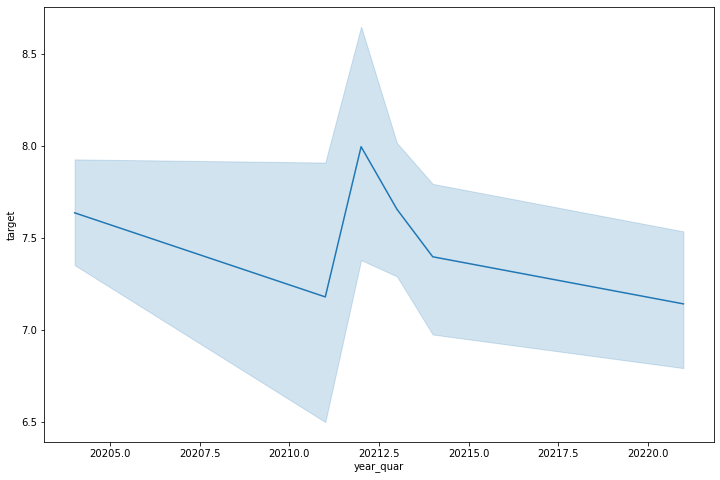

In [63]:
plt.figure(figsize=(12,8))
sns.lineplot(data_train.year_quar, data.target)

### do I need quarter?

<AxesSubplot:xlabel='year_quar', ylabel='target'>

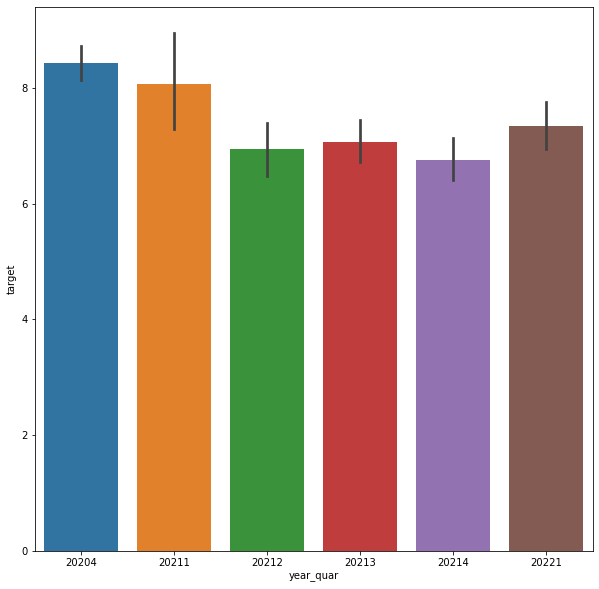

In [64]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'year_quar' ,y = 'target', data = data_train, estimator=np.mean)

In [65]:
categorical_columns.append('year_quar')

### 2.2.6 'country_from' and 'country_living' column
Country name teacher is from.

In [66]:
# prepare functions
def country_from_prepare(data):
    data.country_from = [x.split('From ')[1] for x in data.country_from]
    
def country_living_prepare(data):
    #UTC difference
    data['UTC_diff'] = [x.split('UTC')[1].split(':')[0] for x in data.country_living]
    data.UTC_diff = data.UTC_diff.astype('int')
    
    data.country_living = [x.split(', ')[1].split(' (')[0] for x in data.country_living]



# most common countries   
def most_common_countries(data, column):
    #List of most common countries
    countries_from_dict = dict(data_train[column].value_counts())
    countries_from_most_common = list(dict(filter(lambda elem: elem[1]>50,countries_from_dict.items())).keys())
    
    data[column] = [country if country in countries_from_most_common 
                         else 'Other' for country in data[column]]

# country from total
def country_new(data):
    #preparation
    country_from_prepare(data)
    country_living_prepare(data)
    
    #update
    most_common_countries(data, 'country_from')
    most_common_countries(data, 'country_living')    

In [67]:
country_new(data_train)
country_new(data_test)

In [68]:
categorical_columns.extend(['country_from', 'country_living', 'UTC_diff'])

### 2.2.7 'rating' column

In [69]:
data_train.rating = data_train.rating.astype('float')
data_test.rating = data_test.rating.astype('float')

In [70]:
numerical_columns.append('rating')

### 2.2.8 'students_num', 'lessons_num', 'attendance', 'response', 'reviews_num' columns.
'students_num' - Number of techers' students. <br/>
'lessons_num' - Number of techers' lessons. <br/>
'attendance' - Percentage of teachers' attendance. <br/>
'response' - Percentage of teachers' response. <br/>
'reviews_num' - Number of reviews.

In [71]:
data_train[['students_num', 'lessons_num', 'attendance', 'response', 'reviews_num']]

,students_num,lessons_num,attendance,response,reviews_num
0,91,348,100%,100%,42 Reviews
1,25,191,100%,100%,10 Reviews
2,35,127,100%,93%,13 Reviews
3,7,7,100%,100%,2 Reviews
4,122,560,100%,100%,90 Reviews
...,...,...,...,...,...
1554,51,220,100%,99%,50 Reviews
1555,37,70,97%,98%,14 Reviews
1556,210,"1,438",100%,100%,125 Reviews
1557,117,536,100%,100%,46 Reviews


In [72]:
num_cols = ['students_num', 'lessons_num', 'attendance', 'response', 'reviews_num']

In [73]:
def num_cols_func(data, col):
    data[col].fillna(0, inplace=True)
    data[col] = data[col].astype('str')
    data[col] = [re.sub('[^0-9]+', '', x) for x in data[col]]
    data[col] = [x if x!='' else 0 for x in data[col]]
    data[col] = data[col].astype('int')

In [74]:
for col in num_cols:
    num_cols_func(data_train, col)
    num_cols_func(data_test, col)

In [75]:
numerical_columns.extend(num_cols)

## 2.3 Text columns

In [76]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split

from catboost import CatBoostRegressor

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [77]:
data.columns

Index(['link', 'teacher_type', 'is_native', 'languages', 'about_info',
       'since_date', 'main_info', 'country_from', 'country_living', 'rating',
       'students_num', 'lessons_num', 'attendance', 'response', 'target',
       'teacher_style', 'lessons_style', 'resume', 'reviews_num'],
      dtype='object')

In [78]:
text_columns_all = ['about_info', 'main_info', 'teacher_style', 'lessons_style', 'resume']

In [79]:
data_train[text_columns_all]

,about_info,main_info,teacher_style,lessons_style,resume
0,"I am 23 years, I'm from Botswana and I am curr...","Certified TEFL teacher, food blogger and under...","I am a friend rather a teacher, a fun and outg...",Student oriented and repetitive: my lessons ar...,NaN
1,"Hello and welcome, I'm Mindy. I am an American...",TEFL Certified Teacher: I specialize in conver...,I am a native English speaker and a TEFL certi...,"My lessons are quite informal, but I do provid...",2019 - 2021\nBaker/Chef Farmgate Cafe\nFarmgat...
2,"Hello, my name is Ayesha and I am Native Engl...",Qualified English Teacher🌈,Apart from having many years of experience tea...,I create fun and creative lessons to suit each...,2018 - 2021\nBachelor's - Education\nUniversit...
3,I am a young tutor who has more than a year of...,"An experienced, passionate and patient tutor","I am a patient, polite and motivating teacher ...",I offer conversational lessons as well as read...,"2021 - 2022\ntutor Preply\nPreply - Gaborone, ..."
4,"I am a friendly, outgoing person with a great ...",1st Class BA Degree - Creative Writing. Over 1...,"I am a friendly, approachable, and empathic te...",I have a nurturing/facilitator/psychological a...,2015 - 2016\nTeaching TEFL England\nTEFL Engla...
...,...,...,...,...,...
1554,"Hello, my name is Vladimir. \n\nЯ носитель рус...",Experienced UK-based TEFL-certified generalist...,I am convinced: a good teacher is a passionate...,I believe that a foreign language is a great t...,NaN
1555,"My name is Zamanguni Ntozakhe, I am a Civil En...","My name is Zamanguni Ntozakhe, I am a Civil En...",As a teacher I am fully aware that our learnin...,I prefer live lessons so we can engage in my c...,NaN
1556,"My name is Tamara. I love traveling, doing yog...",Certified English teacher with over 7 years of...,I speak Russian and elementary Mandarin. I was...,I can cover topics such as basic and conversat...,2014 - 2015\nEnglish Teacher EF English First\...
1557,"Hi! My name is Bron, I’m 28 and I'm from Irela...",Certified ESL Teacher with 4 years experience ...,I believe quality teaching should be affordabl...,I think the fastest way to learn English is by...,NaN


In [80]:
data_train[text_columns_all].fillna('', inplace=True)
data_train['is_resume'] = [1 if t!='' else 0 for t in data_train.resume]

data_test[text_columns_all].fillna('', inplace=True)
data_test['is_resume'] = [1 if t!='' else 0 for t in data_test.resume]

In [81]:
numerical_columns.append('is_resume')

In [82]:
data_train[data_train.about_info == data_train.main_info].shape

(339, 220)

In [83]:
def all_info_prep(data):
    
    data.about_info.fillna('', inplace=True)

    data['all_info'] = [data.about_info[i] if data.about_info[i] == data.main_info[i]
                        else data.about_info[i] + data.main_info[i] 
                        for i in range(data.shape[0])]


In [84]:
all_info_prep(data_train)
all_info_prep(data_test)

In [85]:
text_columns_new = ['all_info', 'teacher_style', 'lessons_style', 'resume']

In [86]:
stopWords = set(stopwords.words('english'))

In [87]:
parameters_grid = {
    'vect__stop_words' : ['english', stopwords],
    'vect__ngram_range' : [(1,2), (2,3), (3,5)],
    'vect__analyzer': ['char_wb','word'],
    'regressor__max_iter' : [50,100],
    'regressor__C' : [0.5, 1]
}

In [88]:
# Предобработка текста

def prepare_text_feature(data, column):
    data[column] = data[column].astype('str')
    data[column] = [re.sub('[^A-z1-9]', ' ', s) for s in data[column]]
    data[column] = [x.lower() for x in data[column]]



In [89]:
for text_column in text_columns_new:
    prepare_text_feature(data_train, text_column)
    prepare_text_feature(data_test, text_column)


In [90]:
best_estimators = []
for col in text_columns_new:
    pipeline = Pipeline(
                    [("vect", CountVectorizer()),
                    ("transformer",  TfidfTransformer()),
                    ("regressor", LinearSVR(random_state=RANDOM_STATE))])
    grid_cv = GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=3)
    grid_cv.fit(data_train[col], data_train.target)
    best_estimators.append(grid_cv.best_estimator_)
    print(f'{col}: best score - {grid_cv.best_score_}.')
    print('-------------------')

all_info: best score - -2.229177727942543.
-------------------
teacher_style: best score - -2.333822796008859.
-------------------
lessons_style: best score - -2.3036777546180174.
-------------------
resume: best score - -2.3126893234237103.
-------------------


In [91]:
data = data_train

In [92]:
binary_columns

['teacher_type',
 'teaches_lang_list_n',
 'native_Russian',
 'native_Spanish',
 'native_English',
 'other_Korean',
 'other_Japanese',
 'other_Afrikaans',
 'other_Russian',
 'other_French',
 'other_Arabic',
 'other_Spanish',
 'other_German',
 'other_Portuguese',
 'other_Italian',
 'other_Zulu',
 'other_Chinese Mandarin']

In [93]:
numerical_columns

['missed_data',
 'rating',
 'students_num',
 'lessons_num',
 'attendance',
 'response',
 'reviews_num',
 'is_resume']

In [94]:
categorical_columns

['native_lang_list_n',
 'other_lang_list_n',
 'year_quar',
 'country_from',
 'country_living',
 'UTC_diff']

In [95]:
text_columns_new

['all_info', 'teacher_style', 'lessons_style', 'resume']

# 3 part

In [96]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [97]:
def data_concat_text(data):
    return pd.concat([data[numerical_columns],data[categorical_columns],data[binary_columns],
                      data[text_columns_new]], axis=1)

In [98]:
data_all = data_concat_text(data_train)
data_all_test = data_concat_text(data_test)

In [99]:
y_all = data_train['target']

In [100]:
X_train, X_val, y_train, y_val = train_test_split(data_all, y_all, test_size=0.2, random_state=0)

In [101]:
print(f'train data shape {X_train.shape} with mean {y_train.mean()}')
print(f'val data shape {X_val.shape} with mean {y_val.mean()}')

train data shape (1247, 35) with mean 7.593360064153965
val data shape (312, 35) with mean 7.668429487179487


In [102]:
def text_preds(train, test, target_train, target_test):
    preds_num_cols = []
    for i in range(len(text_columns_new)):
        col = text_columns_new[i]
        estimator = best_estimators[i]
        estimator.fit(train[col], target_train)
        train_preds = estimator.predict(train[col])
        test_preds = estimator.predict(test[col])
        col_name = f'{col}_preds'
        train[col_name] = train_preds
        test[col_name] = test_preds

        preds_num_cols.append(col_name)
        print(f'mean_absolute_error train {mean_absolute_error(target_train, train_preds)}')
        print(f'mean_absolute_error val {mean_absolute_error(target_test, test_preds)}')
        print('-----------')

In [103]:
text_preds(X_train, X_val, y_train, y_val)

mean_absolute_error train 1.6529570778622025
mean_absolute_error val 2.1616076959936668
-----------
mean_absolute_error train 1.5551721018388378
mean_absolute_error val 2.2877014850290096
-----------
mean_absolute_error train 1.7712152024231098
mean_absolute_error val 2.291422473033513
-----------
mean_absolute_error train 1.9971828840821666
mean_absolute_error val 2.273752883578994
-----------


In [104]:
text_preds(data_train, data_test, data_train.target, data_test.target)

mean_absolute_error train 1.6378511828782623
mean_absolute_error val 2.2509565293046374
-----------
mean_absolute_error train 1.5309576810816314
mean_absolute_error val 2.345540956432636
-----------
mean_absolute_error train 1.7752698809122693
mean_absolute_error val 2.3434814191796356
-----------
mean_absolute_error train 1.9801746790926198
mean_absolute_error val 2.315249785005962
-----------


In [105]:
X_train.columns

Index(['missed_data', 'rating', 'students_num', 'lessons_num', 'attendance',
       'response', 'reviews_num', 'is_resume', 'native_lang_list_n',
       'other_lang_list_n', 'year_quar', 'country_from', 'country_living',
       'UTC_diff', 'teacher_type', 'teaches_lang_list_n', 'native_Russian',
       'native_Spanish', 'native_English', 'other_Korean', 'other_Japanese',
       'other_Afrikaans', 'other_Russian', 'other_French', 'other_Arabic',
       'other_Spanish', 'other_German', 'other_Portuguese', 'other_Italian',
       'other_Zulu', 'other_Chinese Mandarin', 'all_info', 'teacher_style',
       'lessons_style', 'resume', 'all_info_preds', 'teacher_style_preds',
       'lessons_style_preds', 'resume_preds'],
      dtype='object')

In [106]:
preds_num_cols =['all_info_preds', 'teacher_style_preds',
       'lessons_style_preds', 'resume_preds']

In [107]:
numerical_columns.extend(preds_num_cols)

In [108]:
X_train = pd.concat([X_train[numerical_columns],X_train[categorical_columns],X_train[binary_columns]], axis=1)
X_val = pd.concat([X_val[numerical_columns],X_val[categorical_columns],X_val[binary_columns]], axis=1)

X_train_all = pd.concat([data_train[numerical_columns],data_train[categorical_columns],
                        data_train[binary_columns]], axis=1)
y_train_all = data_train.target

X_test_all = pd.concat([data_test[numerical_columns],data_test[categorical_columns],
                       data_test[binary_columns]], axis=1)
y_test_all = data_test.target

In [109]:
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])

data_train[numerical_columns] = scaler.transform(data_train[numerical_columns])
data_test[numerical_columns] = scaler.transform(data_test[numerical_columns])

In [110]:
regressor = CatBoostRegressor(learning_rate= 0.01, max_depth=5, subsample=0.75, cat_features=categorical_columns,
                              n_estimators=2000, loss_function='MAE', silent=True, random_state=0)
regressor.fit(X_train, y_train)

preds_train = [round(x) for x in regressor.predict(X_train)]
preds_val = regressor.predict(X_val)

print(f'Train: {mean_absolute_error(y_train, preds_train)}')
print(f'Val: {mean_absolute_error(y_val, preds_val)}')

Train: 0.7930392943063352
Val: 1.9875530176406329


In [111]:
regressor = CatBoostRegressor(learning_rate= 0.1, max_depth=4, subsample=0.75, cat_features=categorical_columns,
                              n_estimators=4000, loss_function='MAE', silent=True, random_state=0)
regressor.fit(X_train, y_train)

preds_train = [round(x) for x in regressor.predict(X_train)]
preds_val = regressor.predict(X_val)

print(f'Train: {mean_absolute_error(y_train, preds_train)}')
print(f'Val: {mean_absolute_error(y_val, preds_val)}')

Train: 0.5597273456295109
Val: 2.070715629830695


In [112]:
regressor = CatBoostRegressor(learning_rate= 0.01, max_depth=5, subsample=0.75, cat_features=categorical_columns,
                              n_estimators=2000, loss_function='MAE', silent=True, random_state=0)

regressor.fit(X_train, y_train)

preds_train = [round(x) for x in regressor.predict(X_train)]
preds_val = regressor.predict(X_val)

print(f'Train: {mean_absolute_error(y_train, preds_train)}')
print(f'Val: {mean_absolute_error(y_val, preds_val)}')

Train: 0.7930392943063352
Val: 1.9875530176406329


### test preds

In [113]:
regressor = CatBoostRegressor(learning_rate= 0.01, max_depth=5, subsample=0.75, cat_features=categorical_columns,
                              n_estimators=2000, loss_function='MAE', silent=True, random_state=0)

regressor.fit(X_train_all, y_train_all)

preds_train_all = [round(x) for x in regressor.predict(X_train_all)]
preds_test_all = regressor.predict(X_test_all)

print(f'Train: {mean_absolute_error(y_train_all, preds_train_all)}')
print(f'Val: {mean_absolute_error(y_test_all, preds_test_all)}')

Train: 0.8372867222578576
Val: 2.1960261468819704


In [115]:
y_train.values[:10]

array([15.,  5.,  5., 10.,  5.,  8.,  5.,  6.,  8.,  5.])

In [116]:
preds_train[:10]

[12, 5, 5, 10, 6, 8, 5, 6, 8, 5]

In [117]:
y_train_all.values[:10]

array([5.  , 8.  , 5.  , 5.  , 5.  , 6.99, 5.  , 7.95, 7.8 , 5.  ])

In [118]:
preds_train_all[:10]

[5, 9, 5, 5, 5, 7, 5, 9, 8, 5]

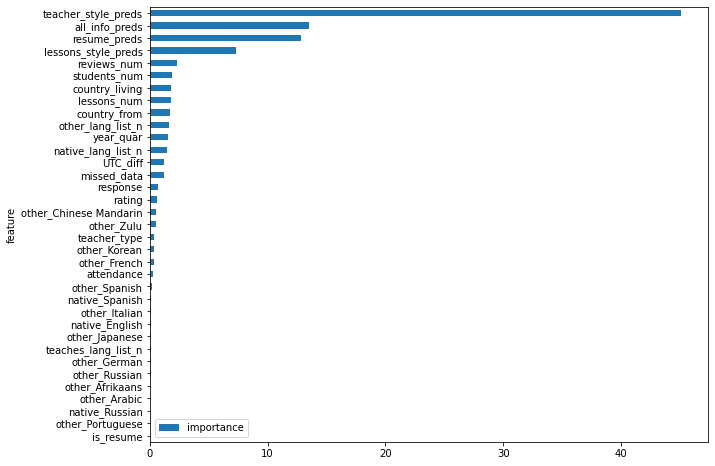

In [119]:
importance = pd.DataFrame({'feature':X_train.columns, 'importance': regressor.feature_importances_})
importance.sort_values('importance', ascending=True).set_index('feature').plot(kind='barh',figsize=(10,8))
plt.show()



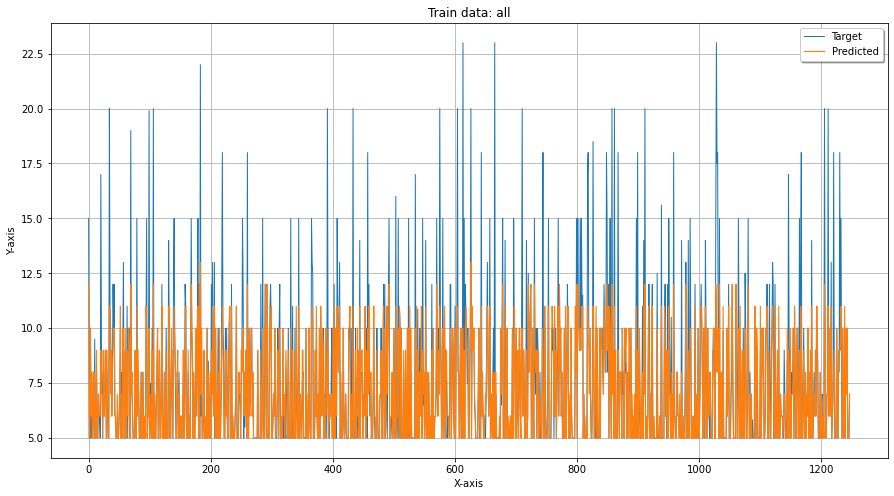

In [120]:
x_ax = range(len(y_train))
plt.figure(figsize=(15,8))
plt.plot(x_ax, y_train, linewidth=1, label="Target")
plt.plot(x_ax, preds_train, linewidth=1.1, label="Predicted")
plt.title("Train data: all")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

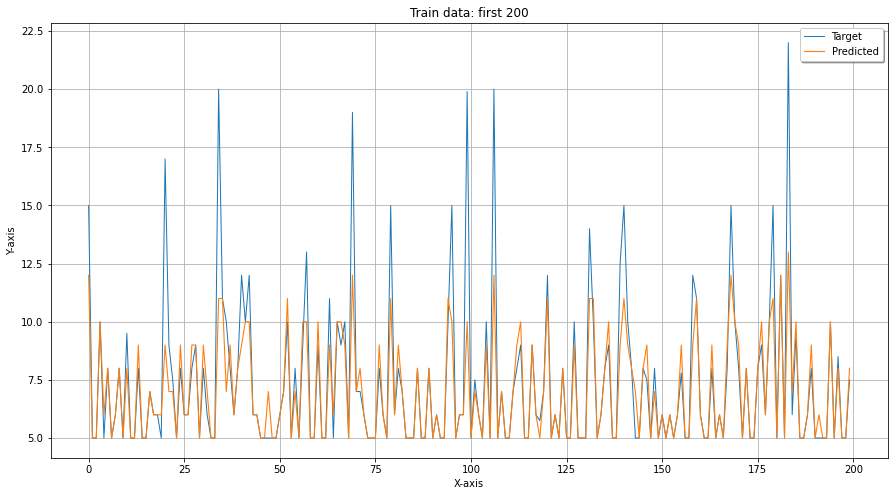

In [121]:
x_ax = range(len(y_train[:200]))
plt.figure(figsize=(15,8))
plt.plot(x_ax, y_train[:200], linewidth=1, label="Target")
plt.plot(x_ax, preds_train[:200], linewidth=1.1, label="Predicted")
plt.title("Train data: first 200")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

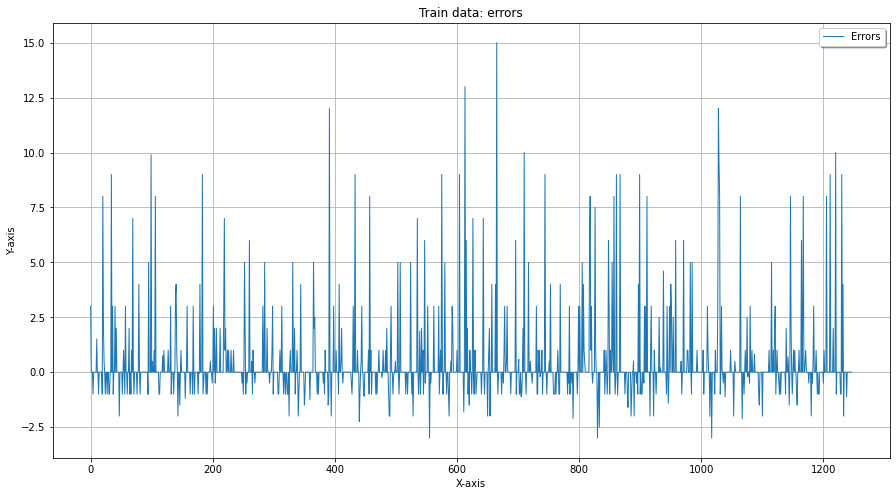

In [122]:
x_ax = range(len(y_train))
plt.figure(figsize=(15,8))
plt.plot(x_ax, y_train - preds_train, linewidth=1, label="Errors")
plt.title("Train data: errors")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

Under prediction

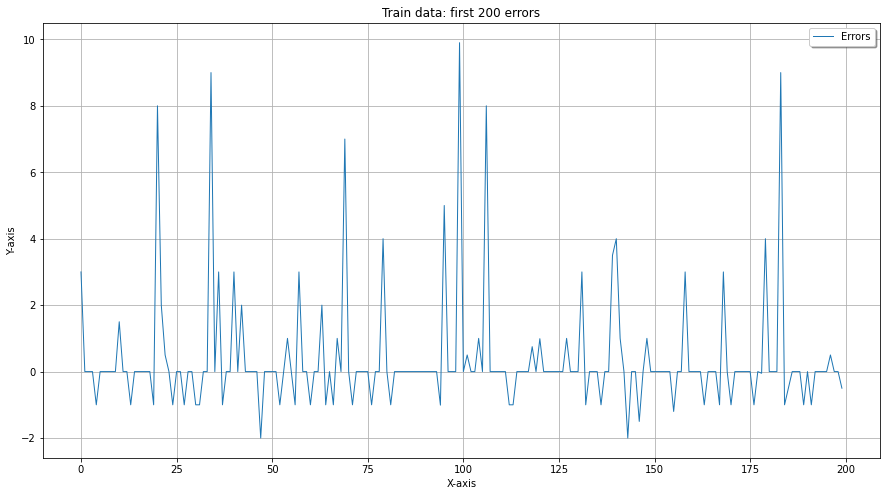

In [123]:
x_ax = range(len(y_train[:200]))
plt.figure(figsize=(15,8))
plt.plot(x_ax,y_train[:200] - preds_train[:200], linewidth=1, label="Errors")
plt.title("Train data: first 200 errors")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 